## Catalyst - So many Faces

First of all, let's install the requirements, download the dataset, and import all python dependencies.


### Requirements 
Today we would use Catalyst and Albumentations libraries.
*\
[Catalyst](https://github.com/catalyst-team/catalyst) is the PyTorch framework for Deep Learning research and development. It focuses on reproducibility, rapid experimentation, and codebase reuse so you can create something new rather than write another regular train loop.*


### Dataset 
For the tutorial purpose, we would use [imagewoof2](https://catalyst-team.github.io/catalyst/api/contrib.html#catalyst.contrib.datasets.cv.imagewoof.Imagewoof) classification dataset.
*\
Imagewoof is a subset of 10 classes from Imagenet that aren't so easy to classify, since they're all dog breeds. The breeds are: Australian terrier, Border terrier, Samoyed, Beagle, Shih-Tzu, English foxhound, Rhodesian ridgeback, Dingo, Golden retriever, Old English sheepdog. Source: [fastai/imagenette](https://github.com/fastai/imagenette#imagewoof).*


### Imports
We need to import all the required PyTorch dependencies and all Catalyst supported Faces implementations for our benchmark tutorial.


In [1]:
# !pip install -U catalyst==20.12 albumentations==0.5.2 &> /dev/null
# !source catalystenv/bin/activate
# !pip install keras
# !pip install tensorflow

# import pip
# pip.main(["install", "grad-cam"])
# pip.main(["install", "seaborn"])
# pip.main(["install", "colorcet"])

#there's a .ipynb_checkpoints folder that got created in the Heliconius erato ssp. lativitta folder (removed background, 256x256 original)
# !rm -rf "/fs/ess/PAS2136/Butterfly/Model_Mimic/model_mimic_images_256_256_removed_background/Heliconius erato ssp. lativitta/.ipynb_checkpoints"

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tensorboardX import SummaryWriter

from sklearn.model_selection import train_test_split

import albumentations as albu
from albumentations.pytorch.transforms import ToTensorV2

from torchvision.models import resnet
from tqdm import tqdm 
import torchvision
import torchvision.transforms as T

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import cm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import PIL
import copy

import catalyst.dl as dl
from catalyst.contrib.nn import (
    ArcFace,
    CosFace,
    AdaCos,
    SubCenterArcFace,
    CurricularFace,
    ArcMarginProduct,
)

In [4]:
# gradcam: https://github.com/jacobgil/pytorch-grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Device: ",device)

if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

Device:  cpu


## Select Acuity and Model

In [6]:
## ----- uncomment the name of the dataset you want to work with ------
# acuity = 'no_acuity_white_background'
acuity = 'no_acuity'
# acuity = 'heliconius_male_behavioral_acuity' #retrained for eratonet
# acuity = 'heliconius_female_behavioral_acuity' #retrained for eratonet
# acuity = 'heliconius_male_morphological_acuity' #retrained for eratonet
# acuity = 'heliconius_female_morphological_acuity' #retrained for eratonet
# acuity = 'kingfisher_acuity' #retrained for eratonet

## ----- uncomment model name ------
model_name = 'RegularSpeciesClassification'
# model_name = 'EratoNet'
# model_name = 'MelpomeneNet'
# model_name = 'MimicsNet'

print('Acuity: ', acuity)
print('Model: ', model_name)

Acuity:  no_acuity
Model:  RegularSpeciesClassification


In [7]:
print(model_name)
if model_name == 'EratoNet':
    erato_net = True
    melpomene_net = False
    mimic_net = False
    n_classes = 10

elif model_name == 'MelpomeneNet':
    erato_net = False
    melpomene_net = True
    mimic_net = False
    n_classes = 10
    
elif model_name == 'MimicsNet':
    erato_net = False
    melpomene_net = False
    mimic_net = True
    n_classes = 10
    
elif model_name == 'RegularSpeciesClassification':
    erato_net = False
    melpomene_net = False
    mimic_net = False
    n_classes = 20

num_classes = n_classes
num_classes

RegularSpeciesClassification


20

## Data

Get the path to the dataset containing the images we want to work with

In [8]:
from src.dir_paths.dataset_paths import get_image_dataset_path
from src.dir_paths.train_val_test_paths import get_split_csvs

#path to images with the applied selected acuity
dataset_path = get_image_dataset_path(acuity)

#path to train/val/test split csvs 
main = get_split_csvs(acuity, model_name)

print('Image Dataset:', dataset_path)
print('Data Split: ', main)

Image Dataset: /fs/ess/PAS2136/Butterfly/Model_Mimic/model_mimic_images_256_256_removed_background_dorsal/
Data Split:  /fs/ess/PAS2136/Butterfly/Model_Mimic/Data_Splits/RegularSpeciesClassification/model_mimic_images_256_256_removed_background_dorsal/


### (Optional) load in all images from our dataset (3822 images - dorsal only)

100%|██████████| 20/20 [00:01<00:00, 13.46it/s]


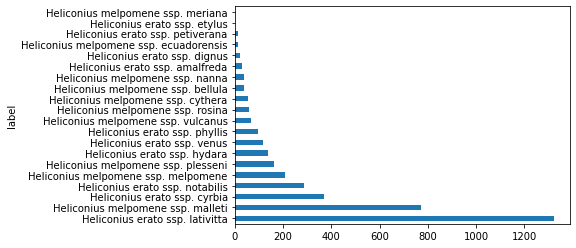

In [9]:
# (optional) load in all images from our dataset (3822 images - dorsal only)
species_df = pd.DataFrame()
for species in tqdm(os.listdir(dataset_path)):
    species_imgs_path = os.path.join(dataset_path, species)
    for img in os.listdir(species_imgs_path):
        img_file_path = os.path.join(species_imgs_path, img)
        label = species
        dict_species = {'path':img_file_path, 'label':label}
        species_df = pd.concat([species_df, pd.DataFrame([dict_species])], ignore_index=True)

# remove /.ipynb_checkpoints entries
ipynb_ckpts = []
for p in list(species_df.path):
    img_name = p.split('/')[-1]
    if img_name == '.ipynb_checkpoints':
        ipynb_ckpts.append(p)
        
species_df = species_df[~species_df.path.isin(ipynb_ckpts)].copy(deep=True).reset_index(drop=True)
#plot distribution of species classes in our dataset
# display(species_df.label.value_counts())
species_df.label.value_counts().plot(kind='barh');

In [10]:
species_df.shape
species_df.label.value_counts()

label
Heliconius erato ssp. lativitta           1321
Heliconius melpomene ssp. malleti          773
Heliconius erato ssp. cyrbia               370
Heliconius erato ssp. notabilis            287
Heliconius melpomene ssp. melpomene        210
Heliconius melpomene ssp. plesseni         162
Heliconius erato ssp. hydara               140
Heliconius erato ssp. venus                119
Heliconius erato ssp. phyllis               97
Heliconius melpomene ssp. vulcanus          69
Heliconius melpomene ssp. rosina            60
Heliconius melpomene ssp. cythera           55
Heliconius melpomene ssp. bellula           38
Heliconius melpomene ssp. nanna             38
Heliconius erato ssp. amalfreda             30
Heliconius erato ssp. dignus                23
Heliconius melpomene ssp. ecuadorensis      13
Heliconius erato ssp. petiverana            12
Heliconius erato ssp. etylus                 3
Heliconius melpomene ssp. meriana            2
Name: count, dtype: int64

In [311]:
print(len(species_df[species_df.label.str.contains('melpomene')])) #1418
species_df[species_df.label.str.contains('melpomene')].label.value_counts()

1418


label
Heliconius melpomene ssp. malleti         772
Heliconius melpomene ssp. melpomene       210
Heliconius melpomene ssp. plesseni        161
Heliconius melpomene ssp. vulcanus         69
Heliconius melpomene ssp. rosina           60
Heliconius melpomene ssp. cythera          55
Heliconius melpomene ssp. nanna            38
Heliconius melpomene ssp. bellula          38
Heliconius melpomene ssp. ecuadorensis     13
Heliconius melpomene ssp. meriana           2
Name: count, dtype: int64

In [313]:
print(len(species_df[species_df.label.str.contains('erato')])) #2396
species_df[species_df.label.str.contains('erato')].label.value_counts()

2396


label
Heliconius erato ssp. lativitta     1319
Heliconius erato ssp. cyrbia         368
Heliconius erato ssp. notabilis      285
Heliconius erato ssp. hydara         140
Heliconius erato ssp. venus          119
Heliconius erato ssp. phyllis         97
Heliconius erato ssp. amalfreda       30
Heliconius erato ssp. dignus          23
Heliconius erato ssp. petiverana      12
Heliconius erato ssp. etylus           3
Name: count, dtype: int64

## Map species string labels to categorical numerical labels

### RegularSpeciesClassification

In [7]:
#using the structure of subspecies folders, assign a numerical categorical id to each subspecies
# species_list = os.listdir(dataset_path)
# species2index = {species:i for i, species in enumerate(species_list)}
# index2species = {i:species for i, species in enumerate(species_list)}
# display(index2species)

index2species = {0: 'Heliconius melpomene ssp. ecuadorensis',
 1: 'Heliconius melpomene ssp. nanna',
 2: 'Heliconius melpomene ssp. rosina',
 3: 'Heliconius erato ssp. phyllis',
 4: 'Heliconius erato ssp. dignus',
 5: 'Heliconius melpomene ssp. bellula',
 6: 'Heliconius erato ssp. lativitta',
 7: 'Heliconius melpomene ssp. vulcanus',
 8: 'Heliconius erato ssp. etylus',
 9: 'Heliconius melpomene ssp. plesseni',
 10: 'Heliconius melpomene ssp. malleti',
 11: 'Heliconius erato ssp. cyrbia',
 12: 'Heliconius erato ssp. amalfreda',
 13: 'Heliconius erato ssp. venus',
 14: 'Heliconius erato ssp. hydara',
 15: 'Heliconius melpomene ssp. meriana', 
 16: 'Heliconius erato ssp. petiverana',
 17: 'Heliconius melpomene ssp. cythera',
 18: 'Heliconius erato ssp. notabilis',
 19: 'Heliconius melpomene ssp. melpomene'}

species2index = {v:k for k,v in index2species.items()}

comimic_dict = {"Heliconius melpomene ssp. malleti": "Heliconius erato ssp. lativitta",
                "Heliconius melpomene ssp. melpomene": "Heliconius erato ssp. hydara", 
                "Heliconius melpomene ssp. plesseni": "Heliconius erato ssp. notabilis",
                "Heliconius melpomene ssp. vulcanus": "Heliconius erato ssp. venus",
                "Heliconius melpomene ssp. rosina": "Heliconius erato ssp. petiverana",
                "Heliconius melpomene ssp. cythera": "Heliconius erato ssp. cyrbia", 
                "Heliconius melpomene ssp. nanna": "Heliconius erato ssp. phyllis",
                "Heliconius melpomene ssp. bellula": "Heliconius erato ssp. dignus",
                "Heliconius melpomene ssp. ecuadorensis": "Heliconius erato ssp. etylus", 
                "Heliconius melpomene ssp. meriana": "Heliconius erato ssp. amalfreda"}

### EratoNet & MelpomeneNet & MimicsNet

Labels have to be sequentially encoded

In [8]:
index2species_erato = {
0: 'Heliconius erato ssp. phyllis',
1: 'Heliconius erato ssp. dignus',
2: 'Heliconius erato ssp. lativitta',
3: 'Heliconius erato ssp. etylus',
4: 'Heliconius erato ssp. cyrbia',
5: 'Heliconius erato ssp. amalfreda', #meriana is the melpomene mimic
6: 'Heliconius erato ssp. venus',
7: 'Heliconius erato ssp. hydara',
8: 'Heliconius erato ssp. petiverana',
9: 'Heliconius erato ssp. notabilis'}

index2species_melpomene = {
0: 'Heliconius melpomene ssp. nanna',
1: 'Heliconius melpomene ssp. bellula',
2: 'Heliconius melpomene ssp. malleti',
3: 'Heliconius melpomene ssp. ecuadorensis',
4: 'Heliconius melpomene ssp. cythera',
5: 'Heliconius melpomene ssp. meriana', #Missing from index2species in dorsal images
6: 'Heliconius melpomene ssp. vulcanus',
7: 'Heliconius melpomene ssp. melpomene',
8: 'Heliconius melpomene ssp. rosina',
9: 'Heliconius melpomene ssp. plesseni',
}

index2species_mimics = {
     0:'mimic_0',
     1:'mimic_1',
     2:'mimic_2',
     3:'mimic_3',
     4:'mimic_4',
     5:'mimic_5',
     6:'mimic_6',
     7:'mimic_7',
     8:'mimic_8',
     9:'mimic_9'

}

#indices in the dictionaries above are assigned such that the mimic pair will share the same numerical label

species2index_erato = {v:k for k,v in index2species_erato.items()}
species2index_melpomene = {v:k for k,v in index2species_melpomene.items()}

species2index_mimics = copy.deepcopy(species2index_erato)
species2index_mimics.update(species2index_melpomene)


In [49]:
species2index_mimics

{'Heliconius erato ssp. phyllis': 0,
 'Heliconius erato ssp. dignus': 1,
 'Heliconius erato ssp. lativitta': 2,
 'Heliconius erato ssp. etylus': 3,
 'Heliconius erato ssp. cyrbia': 4,
 'Heliconius erato ssp. amalfreda': 5,
 'Heliconius erato ssp. venus': 6,
 'Heliconius erato ssp. hydara': 7,
 'Heliconius erato ssp. petiverana': 8,
 'Heliconius erato ssp. notabilis': 9,
 'Heliconius melpomene ssp. nanna': 0,
 'Heliconius melpomene ssp. bellula': 1,
 'Heliconius melpomene ssp. malleti': 2,
 'Heliconius melpomene ssp. ecuadorensis': 3,
 'Heliconius melpomene ssp. cythera': 4,
 'Heliconius melpomene ssp. meriana': 5,
 'Heliconius melpomene ssp. vulcanus': 6,
 'Heliconius melpomene ssp. melpomene': 7,
 'Heliconius melpomene ssp. rosina': 8,
 'Heliconius melpomene ssp. plesseni': 9}

In [9]:
main

'/fs/ess/PAS2136/Butterfly/Model_Mimic/Data_Splits/RegularSpeciesClassification/model_mimic_images_256_256_removed_background_dorsal/'

## Read Train/Val/Test Splits

In [10]:
if mimic_net or model_name == 'RegularSpeciesClassification':
    train_df = pd.read_csv(main + 'train.csv')
    val_df = pd.read_csv(main + 'val.csv')
    test_df = pd.read_csv(main + 'test.csv')

    print(train_df.shape) ##2751, 2
    print(val_df.shape) #306, 2
    print(test_df.shape) #765, 2

elif erato_net or melpomene_net:
    train_df = pd.read_csv(main + 'train.csv')
    val_df = pd.read_csv(main + 'val.csv')
    test_df_erato = pd.read_csv(main + 'test_erato.csv')
    test_df_melpomene = pd.read_csv(main + 'test_melpomene.csv')

    print(train_df.shape)
    print(val_df.shape) 
    print(test_df_erato.shape)
    print(test_df_melpomene.shape) 

#Regular and mimics
# (2751, 2)
# (306, 2)
# (765, 2)

#EratoNet (no acuity)
# (1728, 2)
# (241, 2)
# (433, 2)
# (1420, 2)

#MelpomeneNet (no acuity)
# (1022, 2)
# (142, 2)
# (2402, 2)
# (256, 2)

#2402 total erato vs 1420 total melpomene

(2751, 2)
(306, 2)
(765, 2)


In [13]:
#checking that splits for kingfisher acuity dataset add up to 3814 instead of 3822
1724 + 239 + 433 + 1418

3814

## A comparison of class distribution for EratoNet/MelpomeneNet test_erato and test_melpomene sets

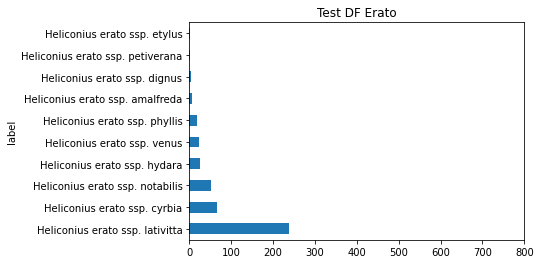

In [11]:
#compare class distributions of EratoNet/MelpomeneNet test_erato and test_melpomene data splits

#EratoNet
#encode the melpomene labels with their erato mimic label
test_df_melpomene.label = [species2index_melpomene[elem] for elem in test_df_melpomene.label]
test_df_melpomene.label = [index2species_erato[i] for i in test_df_melpomene.label]

test_df_erato.label.value_counts().plot(kind='barh', title='Test DF Erato', xlim=(0, 800));

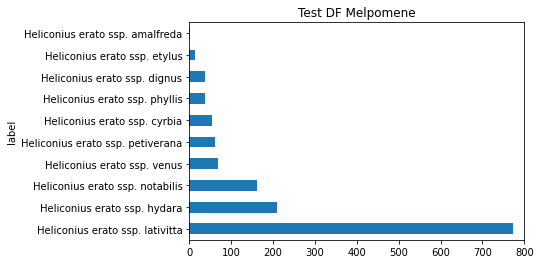

In [14]:
#plot class distribution of test_df_melpomene
test_df_melpomene.label.value_counts().plot(kind='barh', title='Test DF Melpomene', xlim=(0, 800));

Based on the figures above, the class distributions in test_erato and test_melpomene sets DO differ quite significantly, so one way we could rectify this is by `subsampling a smaller subset of images to use as test_melpomene matching the amount and class distribution of test_df_erato`

In [25]:
comimic_dict

{'Heliconius melpomene ssp. malleti': 'Heliconius erato ssp. lativitta',
 'Heliconius melpomene ssp. melpomene': 'Heliconius erato ssp. hydara',
 'Heliconius melpomene ssp. plesseni': 'Heliconius erato ssp. notabilis',
 'Heliconius melpomene ssp. vulcanus': 'Heliconius erato ssp. venus',
 'Heliconius melpomene ssp. rosina': 'Heliconius erato ssp. petiverana',
 'Heliconius melpomene ssp. cythera': 'Heliconius erato ssp. cyrbia',
 'Heliconius melpomene ssp. nanna': 'Heliconius erato ssp. phyllis',
 'Heliconius melpomene ssp. bellula': 'Heliconius erato ssp. dignus',
 'Heliconius melpomene ssp. ecuadorensis': 'Heliconius erato ssp. etylus',
 'Heliconius melpomene ssp. meriana': 'Heliconius erato ssp. amalfreda'}

## Encode Labels for Model

In [11]:
from src.dataloader import read_image, read_sized_image, get_transforms, get_loader

if main.split('/')[7] == "MimicsNet":
    #create lists of image filepaths and their labels for each split
    train_images = list(train_df['path'])
    valid_images = list(val_df['path'])
    test_images = list(test_df['path'])

    #keep a list of the original string labels
    print('Using MimicsNet Labels')
    train_targets_ss = list(train_df['label'])
    valid_targets_ss = list(val_df['label'])
    test_targets_ss = list(test_df['label'])
    
    #encode string subspecies labels --> numbers in a way that mimics share the same label
    train_targets = [species2index_mimics[str(elem).split("/")[7]] for elem in train_images]
    valid_targets = [species2index_mimics[str(elem).split("/")[7]] for elem in valid_images]
    test_targets = [species2index_mimics[str(elem).split("/")[7]] for elem in test_images]
    
elif main.split('/')[7] == "EratoNet":
    print('EratoNet')
    train_images = list(train_df['path'])
    valid_images = list(val_df['path'])
    test_images_erato = list(test_df_erato['path'])
    test_images_melpomene = list(test_df_melpomene['path'])

    train_targets = [species2index_erato[str(elem).split("/")[7]] for elem in train_images]
    valid_targets = [species2index_erato[str(elem).split("/")[7]] for elem in valid_images]
    test_targets_erato = [species2index_erato[str(elem).split("/")[7]] for elem in test_images_erato]
    test_targets_melpomene = [species2index_melpomene[str(elem).split("/")[7]] for elem in test_images_melpomene]
    test_targets_melpomene_actual = [str(elem).split("/")[7] for elem in test_images_melpomene] #so that we have the true melpomene label encodings for each image

    print("Number of train samples -", len(train_images))
    print("Number of valid samples -", len(valid_images))
    print("Number of test erato samples - ",len(test_images_erato))
    print("Number of test melpomene samples - ",len(test_images_melpomene))

elif main.split('/')[7] == "MelpomeneNet":
    print('MelpomeneNet')
    train_images = list(train_df['path'])
    valid_images = list(val_df['path'])
    test_images_erato = list(test_df_erato['path'])
    test_images_melpomene = list(test_df_melpomene['path'])

    train_targets = [species2index_melpomene[str(elem).split("/")[7]] for elem in train_images]
    valid_targets = [species2index_melpomene[str(elem).split("/")[7]] for elem in valid_images]
    test_targets_melpomene = [species2index_melpomene[str(elem).split("/")[7]] for elem in test_images_melpomene]
    test_targets_erato = [species2index_erato[str(elem).split("/")[7]] for elem in test_images_erato]
    test_targets_erato_actual = [str(elem).split("/")[7] for elem in test_images_erato] #so that we have the true erato label encodings for each image

    print("Number of train samples -", len(train_images))
    print("Number of valid samples -", len(valid_images))
    print("Number of test melpomene samples - ",len(test_images_melpomene))
    print("Number of test erato samples - ",len(test_images_erato))

else:
    #regular species classification
    train_images = list(train_df['path'])
    valid_images = list(val_df['path'])
    test_images = list(test_df['path'])

    train_targets = [species2index[str(elem).split("/")[7]] for elem in train_images]
    valid_targets = [species2index[str(elem).split("/")[7]] for elem in valid_images]
    test_targets = [species2index[str(elem).split("/")[7]] for elem in test_images]

    print("Number of train samples -", len(train_images))
    print("Number of valid samples -", len(valid_images))
    print("Number of test samples - ",len(test_images))

#create dataloaders for each split of data
batch = 32
train_dataset, train_loader = get_loader("train", train_images, train_targets, batch_size=batch, num_workers=1)
valid_dataset, valid_loader = get_loader("valid", valid_images, valid_targets, batch_size=batch, num_workers=1)

if erato_net or melpomene_net:
    test_dataset_erato, test_loader_erato, = get_loader("test", test_images_erato, test_targets_erato, batch_size=batch, num_workers=1)
    test_dataset_melpomene, test_loader_melpomene, = get_loader("test", test_images_melpomene, test_targets_melpomene, batch_size=batch, num_workers=1)
    
    #create dictionary with each of our dataloaders
    #only include the ID loader --> leave out the mimic loader for now. We'll work with that one independently
    loaders = { "train": train_loader,
            "valid": valid_loader,
            "test": test_loader_erato if erato_net else test_loader_melpomene
            }

else:
    test_dataset, test_loader, = get_loader("test", test_images, test_targets, batch_size=batch, num_workers=1)
    #create dictionary with each of our dataloaders
    loaders = { "train": train_loader,
            "valid": valid_loader,
            "test": test_loader
            }

loaders

Number of train samples - 2751
Number of valid samples - 306
Number of test samples -  765


{'train': <torch.utils.data.dataloader.DataLoader at 0x2ba487dfba60>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x2ba487e038e0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x2ba487e03820>}

In [74]:
1724 + 239 + 433 + 1418
1728 + 241 + 433 + 1420

3822

## Train Model: ResNet50 + ArcFace

In [75]:
from src.dir_paths.model_log_paths import get_logdir
logdir = get_logdir(acuity, model_name)
print(logdir)

/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet_arcface_logs/EratoNet/model_mimic_images_256_256_removed_background_dorsal


In [76]:
from src.model import ResNetEncoder, EncoderWithHead
from src.embeddings import predict_embeddings, save_embeddings, save_merged_embeddings

## CustomRunner class handles run logic and batch handling
class CustomRunner(dl.Runner):
    def _handle_batch(self, batch):
        # model train/valid step
        features, targets = batch
        logits = self.model(features, targets)

        loss = self.criterion(logits, targets)
        accuracy = (logits.argmax(1) == targets).float().mean().detach().cpu()

        batch_metrics = {
            "loss": loss.item(),
            "accuracy": accuracy.item(),
        }
        self.batch_metrics.update(batch_metrics)

        if self.is_train_loader:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
    def predict_batch(self, batch):
        features, _ = batch
        return F.normalize(self.model.encoder(features.to(self.device)))

In [77]:
#setup model architecture, loss, optimizer, and number of epochs to train for

num_classes = n_classes #20 (0r 10 if mimicsnet, eratonet, melpomene net)

encoder = ResNetEncoder("resnet50", 128)
model   = EncoderWithHead(encoder,
                          ArcFace(128, n_classes, s=2**0.5*np.log(n_classes - 1), m=0.25))

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-5)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

num_epochs = 50

print(logdir)
print(n_classes)

/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet_arcface_logs/EratoNet/model_mimic_images_256_256_removed_background_dorsal
10


In [78]:
#start training
runner = CustomRunner()

runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    logdir = logdir,
    num_epochs=num_epochs,
    main_metric="accuracy",
    minimize_metric=False,
    fp16=False,
    load_best_on_end=True,
    verbose=True
)

#save model for classification - otherwise the ckpt saved by runner gives weird matrix results
torch.save(model.state_dict(), logdir + '/checkpoints/classification_ckpt.pth')

1/50 * Epoch (train): 100% 54/54 [00:32<00:00,  1.67it/s, accuracy=0.875, loss=0.715]   
1/50 * Epoch (valid): 100% 8/8 [00:04<00:00,  1.77it/s, accuracy=0.941, loss=0.748]
1/50 * Epoch (test): 100% 14/14 [00:07<00:00,  1.84it/s, accuracy=0.765, loss=1.313]
[2024-06-17 16:25:48,226] 
1/50 * Epoch 1 (train): accuracy=0.6279 | loss=1.4594
1/50 * Epoch 1 (valid): accuracy=0.8423 | loss=0.9540
1/50 * Epoch 1 (test): accuracy=0.8360 | loss=0.9696
2/50 * Epoch (train): 100% 54/54 [00:09<00:00,  5.67it/s, accuracy=0.906, loss=0.672]
2/50 * Epoch (valid): 100% 8/8 [00:01<00:00,  7.56it/s, accuracy=0.882, loss=1.009]
2/50 * Epoch (test): 100% 14/14 [00:01<00:00,  8.55it/s, accuracy=0.824, loss=1.095]
[2024-06-17 16:26:01,922] 
2/50 * Epoch 2 (train): accuracy=0.9039 | loss=0.7198
2/50 * Epoch 2 (valid): accuracy=0.9336 | loss=0.7125
2/50 * Epoch 2 (test): accuracy=0.9169 | loss=0.7479
3/50 * Epoch (train): 100% 54/54 [00:09<00:00,  5.71it/s, accuracy=0.969, loss=0.461]
3/50 * Epoch (valid): 100

## Load Model 

Load model from saved checkpoints if training has already been completed

In [12]:
from src.utils import load_model
from src.dir_paths.model_log_paths import get_logdir
from src.model import ResNetEncoder, EncoderWithHead

model_path = get_logdir(acuity, model_name) + '/checkpoints/classification_ckpt.pth'

#load in model with weights
num_classes = n_classes #20 (0r 10 if mimicsnet, eratonet, melpomene net)

encoder = ResNetEncoder("resnet50", 128)
model   = EncoderWithHead(encoder,
                          ArcFace(128, n_classes, s=2**0.5*np.log(n_classes - 1), m=0.25))

model = load_model(model, model_path, device)
encoder = model.encoder
device = 'cpu'

print('Model Ckpt:', model_path)
print('Num Classes: ', num_classes)

Model Ckpt: /fs/ess/PAS2136/Butterfly/Model_Mimic/resnet_arcface_logs/RegularSpeciesClassification/model_mimic_images_256_256_removed_background_dorsal/checkpoints/classification_ckpt.pth
Num Classes:  20


## Get Accuracy on Test Split of Data

In [80]:
comimic_dict = {"Heliconius melpomene ssp. malleti": "Heliconius erato ssp. lativitta",
                "Heliconius melpomene ssp. melpomene": "Heliconius erato ssp. hydara", 
                "Heliconius melpomene ssp. plesseni": "Heliconius erato ssp. notabilis",
                "Heliconius melpomene ssp. vulcanus": "Heliconius erato ssp. venus",
                "Heliconius melpomene ssp. rosina": "Heliconius erato ssp. petiverana",
                "Heliconius melpomene ssp. cythera": "Heliconius erato ssp. cyrbia", 
                "Heliconius melpomene ssp. nanna": "Heliconius erato ssp. phyllis",
                "Heliconius melpomene ssp. bellula": "Heliconius erato ssp. dignus",
                "Heliconius melpomene ssp. ecuadorensis": "Heliconius erato ssp. etylus", 
                "Heliconius melpomene ssp. meriana": "Heliconius erato ssp. amalfreda"}

In [81]:
from src.accuracy import get_accuracy

print(model_name)
print(model_path)

if model_name == 'EratoNet':
    mimic_loader = test_loader_melpomene
elif model_name == 'MelpomeneNet':
    mimic_loader = test_loader_erato

if model_name == 'EratoNet' or model_name =='MelpomeneNet':
    # calculate ID and Mimic accuracies
    id_accuracy, all_predicted_ID, all_labels_ID = get_accuracy(model, loaders['test'], split='ID', device=device)
    mimic_accuracy, all_predicted_mimic, all_labels_mimic = get_accuracy(model, mimic_loader, split='mimic', device=device)
else:
    accuracy, all_predicted, all_labels = get_accuracy(model, loaders['test'], split='all', device=device)


EratoNet
/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet_arcface_logs/EratoNet/model_mimic_images_256_256_removed_background_dorsal/checkpoints/classification_ckpt.pth
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([17, 10])
Accuracy of the model on the test (ID) images: 0.9792147806004619
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([3

In [82]:
# len(all_predicted), len(all_labels)
len(all_predicted_ID), len(all_predicted_mimic)

(433, 1420)

In [83]:
if melpomene_net or erato_net:
    print(f'MODEL:          {model_name}')
    print(f'ACUITY:         {acuity}')
    print(f'ID_ACCURACY:    {id_accuracy}')
    print(f'MIMIC_ACCURACY: {mimic_accuracy}')

MODEL:          EratoNet
ACUITY:         no_acuity
ID_ACCURACY:    0.9792147806004619
MIMIC_ACCURACY: 0.9457746478873239


In [84]:
#convert the encoded numerical labels back to subspecies names -  useful for confusion matrix generation in next cells
if erato_net:
    all_predicted_ID_species = np.array([index2species_erato[s] for s in all_predicted_ID]) #map predicted numerical labels to erato string names
    all_label_ID_species = np.array([index2species_erato[s] for s in all_labels_ID]) #map the true numerical labels to erato string names
                                         
    all_predicted_mimic_species = np.array([index2species_erato[s] for s in all_predicted_mimic]) #map predicted labels to erato string names
    all_label_mimic_species = np.array([index2species_melpomene[s] for s in all_labels_mimic]) #map labels to the true melpomene string names

elif melpomene_net:
    all_predicted_ID_species = np.array([index2species_melpomene[s] for s in all_predicted_ID]) #map predicted numerical labels to erato string names
    all_label_ID_species = np.array([index2species_melpomene[s] for s in all_labels_ID]) #map the true numerical labels to erato string names
                                         
    all_predicted_mimic_species = np.array([index2species_melpomene[s] for s in all_predicted_mimic]) #map predicted labels to erato string names
    all_label_mimic_species = np.array([index2species_erato[s] for s in all_labels_mimic]) #map labels to the true melpomene string names
    
# elif mimics_net:
#     all_predicted_species = np.array([index2species_mimics[s] for s in all_predicted]) #what subspecies string label do we encode these back to?
#     all_label_species = test_targets_ss


if melpomene_net or erato_net:
    #get the predicted labels and the frequency of prediction for our test dataloader(s)
    pred_unique_ID, pred_counts_ID = np.unique(all_predicted_ID_species, return_counts=True)
    true_unique_ID, true_counts_ID = np.unique(all_label_ID_species, return_counts=True)

    pred_unique_mimic, pred_counts_mimic = np.unique(all_predicted_mimic_species, return_counts=True)
    true_unique_mimic, true_counts_mimic = np.unique(all_label_mimic_species, return_counts=True)
    
elif model_name == 'RegularSpeciesClassification':
    all_predicted_species = np.array([index2species[s] for s in all_predicted])
    all_label_species = np.array([s for s in all_labels])
    # all_label_species = np.array([index2species[s] for s in all_labels])
    
    pred_unique, pred_counts = np.unique(all_predicted_species, return_counts=True)
    true_unique, true_counts = np.unique(all_label_species, return_counts=True)
    

## EratoNet & MelpomeneNet Confusion Matrices (ID and Mimic)

In [85]:
from src.dir_paths.figures_paths import get_figures_path
cm_save_path = get_figures_path(acuity, model_name)
print(cm_save_path)

/fs/ess/PAS2136/Butterfly/Model_Mimic/Figures/EratoNet/model_mimic_images_256_256_removed_background_dorsal


EratoNet
/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet_arcface_logs/EratoNet/model_mimic_images_256_256_removed_background_dorsal/checkpoints/classification_ckpt.pth


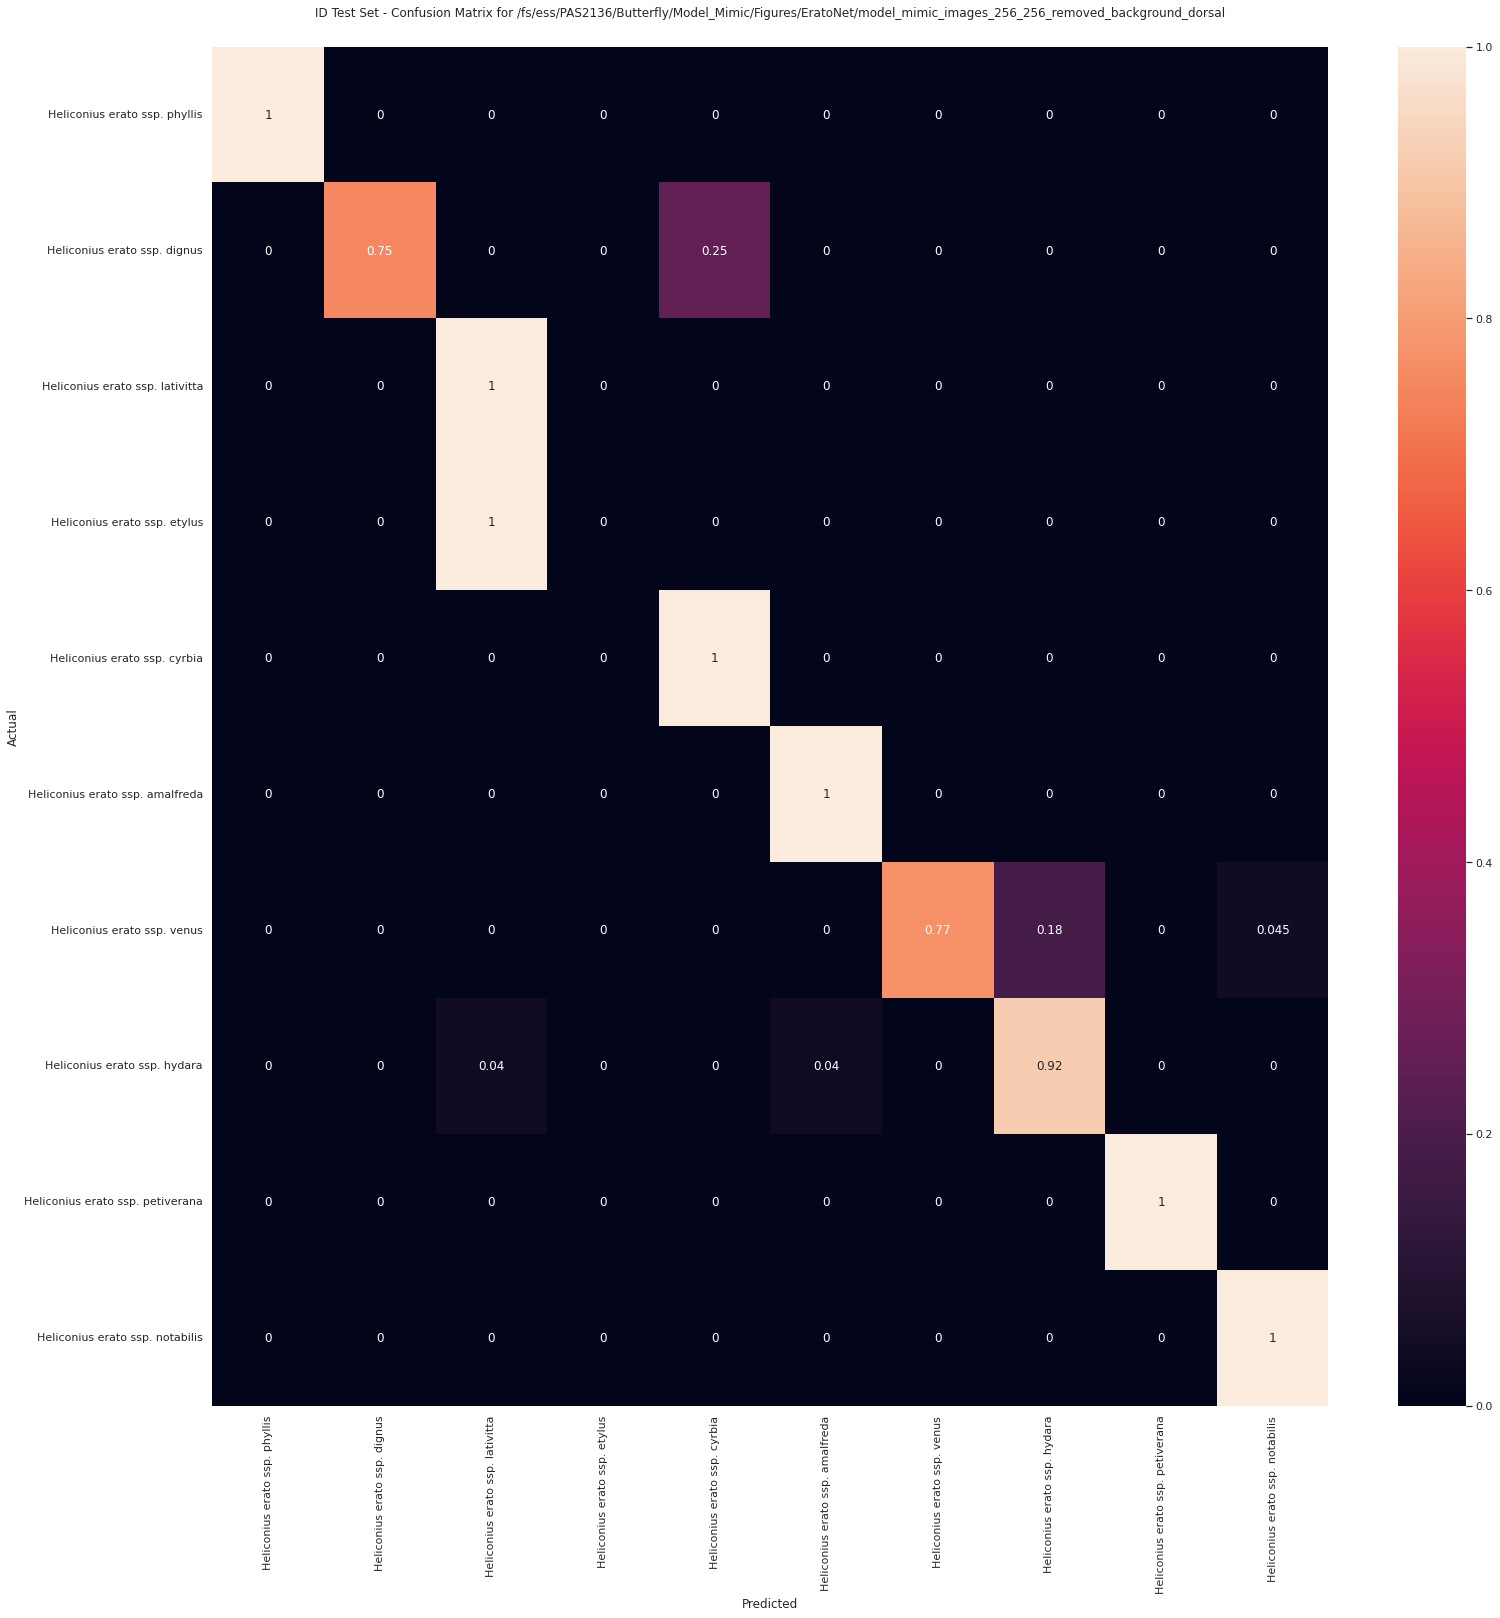

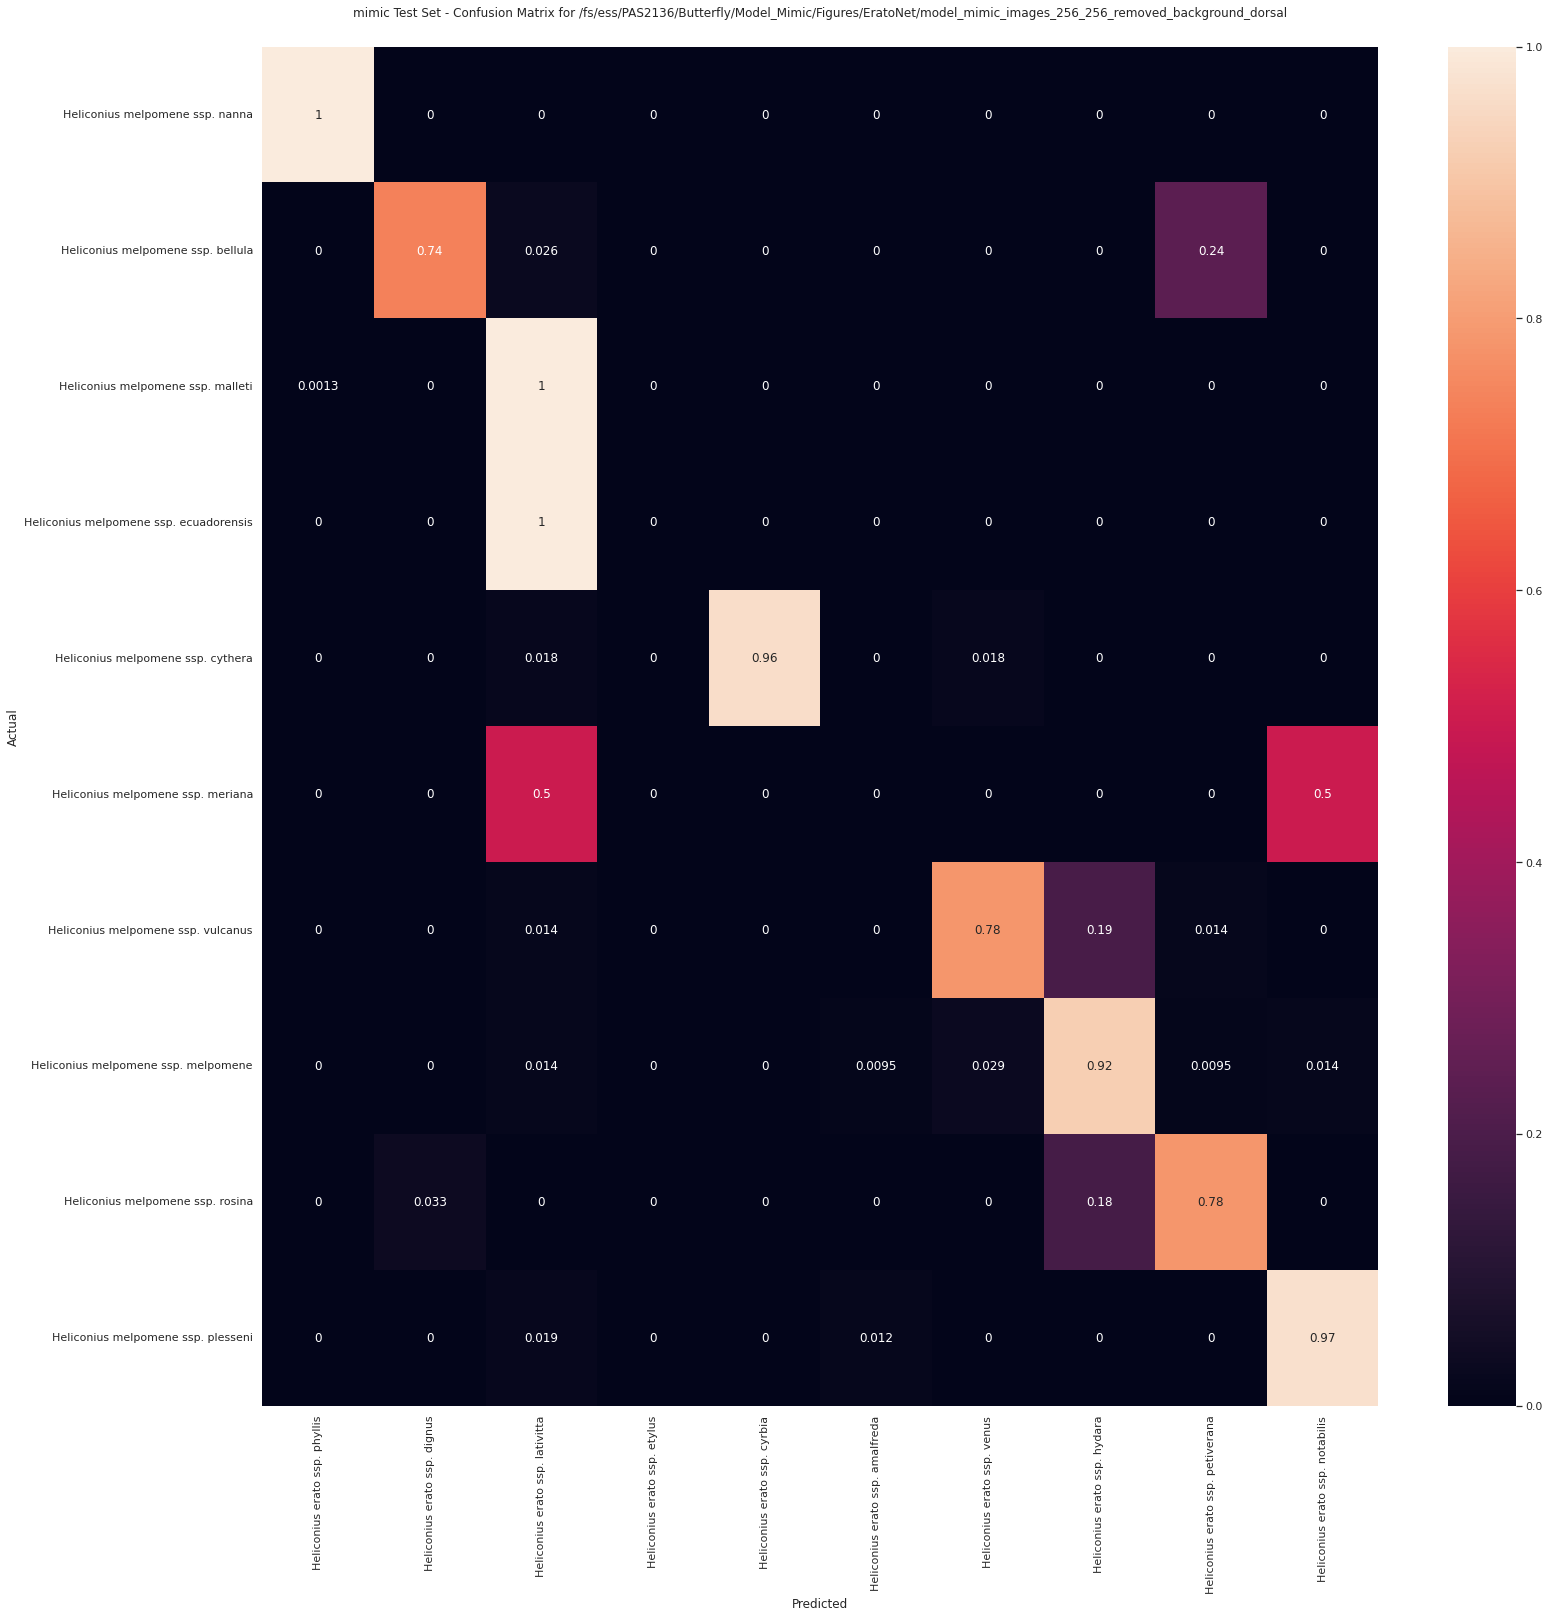

In [86]:
from src.confusion_matrix import create_confusion_matrix

erato_list = list(index2species_erato.values()) 
melpomene_list = list(index2species_melpomene.values()) 
mimic_list = list(index2species_mimics.values())
species_list = list(index2species.values())

print(model_name)
print(model_path)

if model_name == 'EratoNet':
    create_confusion_matrix(all_predicted_ID, 
                            all_labels_ID, 
                            xlist=erato_list, #predicted
                            ylist=erato_list, #actual
                            save_path=cm_save_path, 
                            test_set='ID')
    

    create_confusion_matrix(all_predicted_mimic, 
                            all_labels_mimic, 
                            xlist=erato_list, #predicted
                            ylist=melpomene_list, #actual
                            save_path=cm_save_path, 
                            test_set='mimic')

elif model_name == 'MelpomeneNet':
    create_confusion_matrix(all_predicted_ID, 
                            all_labels_ID, 
                            xlist=melpomene_list, #predicted
                            ylist=melpomene_list, #actual
                            save_path=cm_save_path, 
                            test_set='ID')
    

    create_confusion_matrix(all_predicted_mimic, 
                            all_labels_mimic, 
                            xlist=melpomene_list, #predicted
                            ylist=erato_list, #actual
                            save_path=cm_save_path, 
                            test_set='mimic')

elif model_name == 'MimicsNet':
    create_confusion_matrix(all_predicted, 
                            all_labels, 
                            xlist=mimic_list, #predicted (10 mimic pairs)
                            ylist=mimic_list, #actual (all 20 subspecies)
                            save_path=cm_save_path, 
                            test_set='all')
    
    # create_confusion_matrix(all_predicted, 
    #                         test_targets_ss, 
    #                         xlist=mimic_list, #predicted (10 mimic pairs)
    #                         ylist=mimic_list, #actual (all 20 subspecies)
    #                         save_path=cm_save_path, 
    #                         test_set='all')

elif model_name == 'RegularSpeciesClassification':
    create_confusion_matrix(all_predicted, 
                            all_labels, 
                            xlist=species_list, #predicted (10 mimic pairs)
                            ylist=species_list, #actual (all 20 subspecies)
                            save_path=cm_save_path, 
                            test_set='all')
    

## Predict & Save Embeddings on Test Set
The Resnet-50+ArcFace model generates an embedding vector of length 128 for each image in our test dataset

In [87]:
from src.dir_paths.embedding_paths import get_embedding_paths
save_embeddings_dir = get_embedding_paths(acuity, model_name)

save_embeddings_dir_all = save_embeddings_dir['all']
save_embeddings_dir_train = save_embeddings_dir['train']
save_embeddings_dir_val = save_embeddings_dir['val']

if erato_net or melpomene_net:
    save_embeddings_dir_test_erato = save_embeddings_dir['test_erato']
    save_embeddings_dir_test_melpomene = save_embeddings_dir['test_melpomene']
else:
    save_embeddings_dir_test = save_embeddings_dir['test']

save_embeddings_dir

{'train': '/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/EratoNet/model_mimic_images_256_256_removed_background_dorsal/train_split',
 'val': '/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/EratoNet/model_mimic_images_256_256_removed_background_dorsal/val_split',
 'all': '/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/EratoNet/model_mimic_images_256_256_removed_background_dorsal/train_val_test_split',
 'test_erato': '/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/EratoNet/model_mimic_images_256_256_removed_background_dorsal/test_erato_split',
 'test_melpomene': '/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/EratoNet/model_mimic_images_256_256_removed_background_dorsal/test_melpomene_split'}

### Save Embeddings

In [88]:
from src.embeddings import save_embeddings, save_merged_embeddings
if erato_net:
    index2label = index2species_erato
elif melpomene_net:
    index2label = index2species_melpomene
elif mimic_net:
    index2label = index2species_mimics
else:
    index2label = index2species

#get embeddings for train dataset
train_embeddings, train_labels = save_embeddings(index2label, train_dataset, loaders['train'], encoder, save_embeddings_dir_train, "cuda:0")

#get the embeddings for the val dataset
val_embeddings, val_labels = save_embeddings(index2label, valid_dataset, loaders['valid'], encoder, save_embeddings_dir_val, "cuda:0")

if erato_net or melpomene_net:
    #get the embeddings for our test erato dataset
    test_embeddings_erato, test_labels_erato = save_embeddings(index2species_erato, test_dataset_erato, test_loader_erato, encoder, save_embeddings_dir_test_erato, "cuda:0")

    #get embeddings for the test melpomene dataset
    test_embeddings_melpomene, test_labels_melpomene = save_embeddings(index2species_melpomene, test_dataset_melpomene, test_loader_melpomene, encoder, save_embeddings_dir_test_melpomene, "cuda:0")

    #merge the embeddings across all datasets into one single file
    all_embeddings, all_labels = save_merged_embeddings([train_embeddings, val_embeddings, test_embeddings_erato, test_embeddings_melpomene], 
                                                        [train_labels, val_labels, test_labels_erato, test_labels_melpomene], 
                                                        save_embeddings_dir_all)
else:
    # will have to come back and fix this for mimicrylabelnet and regular species classification
    test_embeddings, test_labels = save_embeddings(index2label, test_dataset, loaders['test'], encoder, save_embeddings_dir_test, "cuda:0")
    
    #merge the embeddings across all datasets into one single file
    all_embeddings, all_labels = save_merged_embeddings([train_embeddings, val_embeddings, test_embeddings], 
                                                        [train_labels, val_labels, test_labels], 
                                                        save_embeddings_dir_all)

#we should only have 3814 total embeddings for kingfisher acuity datasets
print(all_embeddings.shape) #3814 if kingfisher, o.w 3822
print(all_labels.shape) #3814 if kingfisher, o.w 3822 

(3822, 128)
(3822,)


## Load Embeddings

In [13]:
from src.dir_paths.embedding_paths import get_embedding_paths
save_embeddings_dir = get_embedding_paths(acuity, model_name)

save_embeddings_dir_all = save_embeddings_dir['all']
# save_embeddings_dir_all = save_embeddings_dir['all'] + '_GIS' #if you want to visualize the embeddings with access to the filename as the label

tensors_all = save_embeddings_dir_all + '/embeddings/00000/default/tensors.tsv'
metadata_all = save_embeddings_dir_all + '/embeddings/00000/default/metadata.tsv'

print(tensors_all)
print(metadata_all)

/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/RegularSpeciesClassification/model_mimic_images_256_256_removed_background_dorsal/train_val_test_split/embeddings/00000/default/tensors.tsv
/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/RegularSpeciesClassification/model_mimic_images_256_256_removed_background_dorsal/train_val_test_split/embeddings/00000/default/metadata.tsv


In [14]:
from src.utils import load_tsv 

all_embeddings = load_tsv(tensors_all).astype('float32')
all_labels = load_tsv(metadata_all)
all_labels = np.concatenate(all_labels)

print(all_embeddings.shape)
print(all_labels.shape)

(3822, 128)
(3822,)


## Plot tSNE and uMAP

In [15]:
from src.dir_paths.figures_paths import get_figures_path
plot_path = get_figures_path(acuity, model_name)
tsne_plot_title = f"TSNE for Embeddings from {model_name} Model on {dataset_path.split('/')[-2]} Dataset (true labels)"
umap_plot_title = f"uMAP for Embeddings from {model_name} Model on {dataset_path.split('/')[-2]} Dataset (true labels)"
print(tsne_plot_title)
print(umap_plot_title)
print(plot_path)

TSNE for Embeddings from RegularSpeciesClassification Model on model_mimic_images_256_256_removed_background_dorsal Dataset (true labels)
uMAP for Embeddings from RegularSpeciesClassification Model on model_mimic_images_256_256_removed_background_dorsal Dataset (true labels)
/fs/ess/PAS2136/Butterfly/Model_Mimic/Figures/RegularSpeciesClassification/model_mimic_images_256_256_removed_background_dorsal


In [16]:
#create a paired color palette to make tsne easier to read. Colors will be paired based on mimic species
comimic_dict = {"Heliconius melpomene ssp. malleti": "Heliconius erato ssp. lativitta",
                "Heliconius melpomene ssp. melpomene": "Heliconius erato ssp. hydara", 
                "Heliconius melpomene ssp. plesseni": "Heliconius erato ssp. notabilis",
                "Heliconius melpomene ssp. vulcanus": "Heliconius erato ssp. venus",
                "Heliconius melpomene ssp. rosina": "Heliconius erato ssp. petiverana",
                "Heliconius melpomene ssp. cythera": "Heliconius erato ssp. cyrbia", 
                "Heliconius melpomene ssp. nanna": "Heliconius erato ssp. phyllis",
                "Heliconius melpomene ssp. bellula": "Heliconius erato ssp. dignus",
                "Heliconius melpomene ssp. ecuadorensis": "Heliconius erato ssp. etylus", 
                "Heliconius melpomene ssp. meriana": "Heliconius erato ssp. amalfreda"}

melpomene_list = list(comimic_dict.keys())
erato_list = list(comimic_dict.values())
mimic_list = list(index2species_mimics.values())

palette = ["#1f77b4", "#aec7e8",
          "#ff7f0e", "#ffbb78",
          "#2ca02c", "#98df8a",
          "#d62728", "#ff9896",
          "#9467bd", "#c5b0d5",
          "#8c564b", "#c49c94",
          "#e377c2", "#f7b6d2",
          "#7f7f7f", "#c7c7c7",
          "#bcbd22", "#dbdb8d",
          "#17becf", "#9edae5"]

mimic_color_palette = dict()
i = 0

if mimic_net:
    for m in mimic_list:
        mimic_color_palette[m] = palette[i]
        i += 2
    
else:
    for m, e in zip(melpomene_list, erato_list):
        mimic_color_palette[m] = palette[i]
        mimic_color_palette[e] = palette[i+1]
        i += 2

mimic_color_palette

{'Heliconius melpomene ssp. malleti': '#1f77b4',
 'Heliconius erato ssp. lativitta': '#aec7e8',
 'Heliconius melpomene ssp. melpomene': '#ff7f0e',
 'Heliconius erato ssp. hydara': '#ffbb78',
 'Heliconius melpomene ssp. plesseni': '#2ca02c',
 'Heliconius erato ssp. notabilis': '#98df8a',
 'Heliconius melpomene ssp. vulcanus': '#d62728',
 'Heliconius erato ssp. venus': '#ff9896',
 'Heliconius melpomene ssp. rosina': '#9467bd',
 'Heliconius erato ssp. petiverana': '#c5b0d5',
 'Heliconius melpomene ssp. cythera': '#8c564b',
 'Heliconius erato ssp. cyrbia': '#c49c94',
 'Heliconius melpomene ssp. nanna': '#e377c2',
 'Heliconius erato ssp. phyllis': '#f7b6d2',
 'Heliconius melpomene ssp. bellula': '#7f7f7f',
 'Heliconius erato ssp. dignus': '#c7c7c7',
 'Heliconius melpomene ssp. ecuadorensis': '#bcbd22',
 'Heliconius erato ssp. etylus': '#dbdb8d',
 'Heliconius melpomene ssp. meriana': '#17becf',
 'Heliconius erato ssp. amalfreda': '#9edae5'}

In [18]:
# #how to randomly sample n embeddings from a specific class
# embedding_data = pd.DataFrame({'embedding_idx': [i for i in range(len(all_embeddings))],
#                                'label':  all_labels})

# downsampled_embeddings = []
# downsampled_labels = []
# indices = []
# species_list = list(mimic_color_palette.keys())
# n=50 #only take 50 samples from each class
# for species in species_list:
#     if len(embedding_data[embedding_data.label == species]) < n:
#         n_sample = len(embedding_data[embedding_data.label == species])
#     else:
#         n_sample = n
#     idx = embedding_data.label[embedding_data.label.eq(species)].sample(n_sample).index
#     indices += list(idx)
#     downsampled_embeddings += list(all_embeddings[idx])
#     downsampled_labels += list(all_labels[idx])
# downsampled_embeddings = np.array(downsampled_embeddings)
# downsampled_labels = np.array(downsampled_labels)

In [91]:
# save subsampled indices so we can get the same samples
# len(indices) #759 samples
# indices_df = pd.DataFrame({'idx': indices,
#                            'label': downsampled_labels})
# indices_df.to_csv('downsampled_indices.csv', index=False)

In [ ]:
# indices_df = pd.read_csv('downsampled_indices.csv')
# idx = list(indices_df.idx) 
# downsampled_embeddings = all_embeddings[idx]
# downsampled_labels = all_labels[idx]

### TSNE

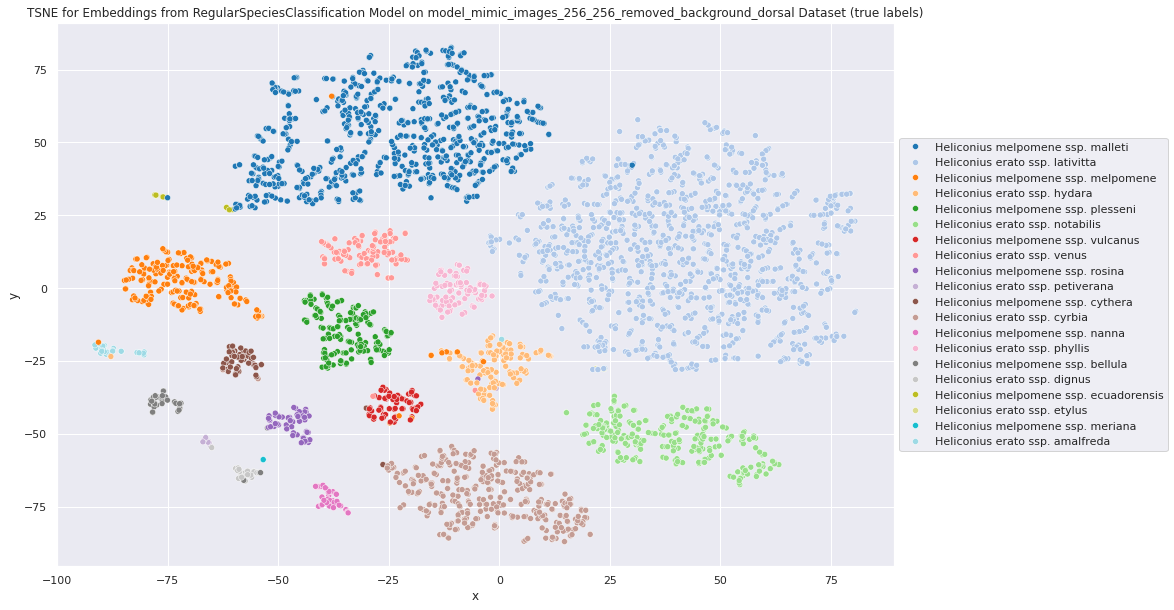

In [19]:
import colorcet as cc
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

#for EratoNet and MelpomeneNet
embeddings = all_embeddings
labels  = all_labels

#downsampling
# embeddings = downsampled_embeddings
# labels  = downsampled_labels

# labels = [p.split('/')[7] for p in all_labels]
# img_names = [p.split('/')[-1] for p in all_labels]

#get tsne embeddings - reduce from 128dim to 2dim
tsne = TSNE(n_components=2, perplexity=5).fit_transform(embeddings)

#create a dataframe out of tsne 2d embeddings with their labels
x = tsne[:, 0]
y = tsne[:, 1]
tsne_embeddings_df = pd.DataFrame({"x": x, "y":y, "label":labels})
# tsne_embeddings_df = tsne_embeddings_df.replace({"label": index2species})

#plot tsne embeddings, color by species
sns.set_theme()
fig, ax = plt.subplots(figsize=(15, 10))

tsne_plot = sns.scatterplot(x="x", y="y", hue="label", data=tsne_embeddings_df, ax=ax, palette=mimic_color_palette);

#reorder our legend so that mimics are after each other
handles, legend_labels = fig.gca().get_legend_handles_labels() 

#get the current order of legend labels
current_order = dict()
for i, label in enumerate(legend_labels):
    current_order[label] = i

#create a mapping of species at the desired legend position
desired_order = dict()
for i, label in enumerate(list(mimic_color_palette.keys())):
    desired_order[i] = label

#reorder current legend labels into desired order
reorder_dict = dict()
for k,v in desired_order.items():
    try:
        reorder_dict[k] = current_order[v]
    except KeyError:
        #meriana is missing due to how we seperated dorsal vs ventral - revisit
        continue

#specify reordered indices only 
order = list(reorder_dict.values())

#pass handle & legend labels lists along with order as below 
plt.legend([handles[i] for i in order], [legend_labels[i] for i in order], loc='center left', bbox_to_anchor=(1, 0.5)) 

#add title to plot
plt.title(tsne_plot_title)
plt.show()

In [187]:
# downsampled_df = pd.DataFrame({'label': downsampled_labels})
# downsampled_df.label.value_counts()#.plot(kind='barh')

In [20]:
# #save tsne plot
# os.makedirs(plot_path, exist_ok=True)
# fig = tsne_plot.get_figure()
# fig.savefig(f"{plot_path}/tsne_plot.png", bbox_inches="tight") 
# # fig.savefig(f"{plot_path}/tsne_plot_downsampled.png", bbox_inches="tight") #use this one for downsampled embedding tsne
# tsne_embeddings_df.shape #(3822, 3) or (3814, 3)

## UMAP

In [26]:
from umap import UMAP
# !pip install umap-learn

RuntimeError: cannot cache function 'rdist': no locator available for file '/users/PAS2136/ramirez528/.conda/envs/classification_exp_env/lib/python3.8/site-packages/umap/layouts.py'

In [21]:
import colorcet as cc
import seaborn as sns
from umap import UMAP
import matplotlib.pyplot as plt

#for EratoNet and MelpomeneNet
embeddings = all_embeddings
labels  = all_labels

#use umap to reduce embeddings to dims
umap_2d = UMAP(n_components=2, init='random', random_state=0)
proj_2d = umap_2d.fit_transform(embeddings)

#create a df of umap embeddings and their labels
x = proj_2d[:, 0]
y = proj_2d[:, 1]
umap_df = pd.DataFrame({"x": x, "y":y, "label":labels})

#plot tsne embeddings, color by species
sns.set_theme()
fig, ax = plt.subplots(figsize=(15, 10))

tsne_plot = sns.scatterplot(x="x", y="y", hue="label", data=tsne_embeddings_df, ax=ax, palette=mimic_color_palette);

#reorder our legend so that mimics are after each other
handles, legend_labels = fig.gca().get_legend_handles_labels() 

#get the current order of legend labels
current_order = dict()
for i, label in enumerate(legend_labels):
    current_order[label] = i

#create a mapping of species at the desired legend position
desired_order = dict()
for i, label in enumerate(list(mimic_color_palette.keys())):
    desired_order[i] = label

#reorder current legend labels into desired order
reorder_dict = dict()
for k,v in desired_order.items():
    try:
        reorder_dict[k] = current_order[v]
    except KeyError:
        #meriana is missing due to how we seperated dorsal vs ventral - revisit
        continue

#specify reordered indices only 
order = list(reorder_dict.values())

#pass handle & legend labels lists along with order as below 
plt.legend([handles[i] for i in order], [legend_labels[i] for i in order], loc='center left', bbox_to_anchor=(1, 0.5)) 

#add title to plot
plt.title(umap_plot_title)
plt.show()

NameError: name 'UMAP' is not defined

In [ ]:
#save tsne plot
os.makedirs(plot_path, exist_ok=True)
fig = tsne_plot.get_figure()
fig.savefig(f"{plot_path}/umap_plot.png", bbox_inches="tight") 
# fig.savefig(f"{plot_path}/tsne_plot_downsampled.png", bbox_inches="tight") #use this one for downsampled embedding tsne
tsne_embeddings_df.shape #(3822, 3) or (3814, 3)

In [95]:
print(model_name, acuity)
# print(accuracy)
# print(f"ID Accuracy: {id_accuracy}")
# print(f"Mimic Accuracy: {mimic_accuracy}")

EratoNet no_acuity


## BoxPlots

In [47]:
from src.dir_paths.embedding_paths import get_embedding_paths
save_embeddings_dir = get_embedding_paths(acuity, model_name)

# or should we limit to just the test splits?
# the `all` category 
save_embeddings_dir_all = save_embeddings_dir['all']
tensors_all = save_embeddings_dir_all + '/embeddings/00000/default/tensors.tsv'
metadata_all = save_embeddings_dir_all + '/embeddings/00000/default/metadata.tsv'

print(tensors_all)
print(metadata_all)

/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/EratoNet/model_mimic_images_256_256_removed_background_kingfisher_acuity_dorsal/train_val_test_split/embeddings/00000/default/tensors.tsv
/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/EratoNet/model_mimic_images_256_256_removed_background_kingfisher_acuity_dorsal/train_val_test_split/embeddings/00000/default/metadata.tsv


In [48]:
print(model_name)

#use the train_val_test_split folders containing both training and testing embeddings to include both erato and melpomene
normal_tensors = f'/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/{model_name}/model_mimic_images_256_256_removed_background_dorsal/train_val_test_split/embeddings/00000/default/tensors.tsv'
normal_metadata = f'/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/{model_name}/model_mimic_images_256_256_removed_background_dorsal/train_val_test_split/embeddings/00000/default/metadata.tsv'

heliconius_male_behavioral_tensors = f'/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/{model_name}/model_mimic_images_256_256_removed_background_heliconius_male_behavioral_acuity_dorsal/train_val_test_split/embeddings/00000/default/tensors.tsv'
heliconius_male_behavioral_metadata = f'/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/{model_name}/model_mimic_images_256_256_removed_background_heliconius_male_behavioral_acuity_dorsal/train_val_test_split/embeddings/00000/default/metadata.tsv'

heliconius_female_behavioral_tensors = f'/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/{model_name}/model_mimic_images_256_256_removed_background_heliconius_female_behavioral_acuity_dorsal/train_val_test_split/embeddings/00000/default/tensors.tsv'
heliconius_female_behavioral_metadata = f'/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/{model_name}/model_mimic_images_256_256_removed_background_heliconius_female_behavioral_acuity_dorsal/train_val_test_split/embeddings/00000/default/metadata.tsv'

heliconius_male_morphological_tensors = f'/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/{model_name}/model_mimic_images_256_256_removed_background_heliconius_male_morphological_acuity_dorsal/train_val_test_split/embeddings/00000/default/tensors.tsv'
heliconius_male_morphological_metadata = f'/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/{model_name}/model_mimic_images_256_256_removed_background_heliconius_male_morphological_acuity_dorsal/train_val_test_split/embeddings/00000/default/metadata.tsv'

heliconius_female_morphological_tensors = f'/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/{model_name}/model_mimic_images_256_256_removed_background_heliconius_female_morphological_acuity_dorsal/train_val_test_split/embeddings/00000/default/tensors.tsv'
heliconius_female_morphological_metadata = f'/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/{model_name}/model_mimic_images_256_256_removed_background_heliconius_female_morphological_acuity_dorsal/train_val_test_split/embeddings/00000/default/metadata.tsv'

kingfisher_tensors = f'/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/{model_name}/model_mimic_images_256_256_removed_background_kingfisher_acuity_dorsal/train_val_test_split/embeddings/00000/default/tensors.tsv'
kingfisher_metadata = f'/fs/ess/PAS2136/Butterfly/Model_Mimic/resnet50_arcface_embeddings/{model_name}/model_mimic_images_256_256_removed_background_kingfisher_acuity_dorsal/train_val_test_split/embeddings/00000/default/metadata.tsv'


EratoNet


In [51]:
from src.utils import load_tsv
names = ['no_acuity', 
         'heliconius_male_behavioral', 
         'heliconius_female_behavioral', 
         'heliconius_male_morphological', 
         'heliconius_female_morphological',
         'kingfisher'
        ]

tensors = [normal_tensors,
           heliconius_male_behavioral_tensors, 
           heliconius_female_behavioral_tensors, 
           heliconius_male_morphological_tensors, 
           heliconius_female_morphological_tensors,
           kingfisher_tensors
          ]

labels = [normal_metadata,
          heliconius_male_behavioral_metadata,
          heliconius_female_behavioral_metadata,
          heliconius_male_morphological_metadata,
          heliconius_female_morphological_metadata,
          kingfisher_metadata
         ]

all_embeddings = dict()
all_labels = dict()

# isolate kingfisher just for a quick sanity check
# for n, (t, l) in zip([names[-1]], zip([tensors[-1]], [labels[-1]])):
for n, (t, l) in zip(names, zip(tensors, labels)):
    embeddings = load_tsv(t)
    labels = load_tsv(l)
    labels = np.concatenate(labels)

    all_embeddings[n] = embeddings
    all_labels[n] = labels

print(len(all_embeddings['no_acuity'])) #3822
print(len(all_embeddings['kingfisher'])) #3814

3822
3814


In [52]:
from src.boxplot import get_boxplot_separate
def tovar(x):
    return Variable(torch.FloatTensor(x).cuda(), requires_grad = False)

#create dict with melpomene --> erato mimic mappings
comimic_dict = {"Heliconius melpomene ssp. malleti": "Heliconius erato ssp. lativitta",
                "Heliconius melpomene ssp. melpomene": "Heliconius erato ssp. hydara", 
                "Heliconius melpomene ssp. plesseni": "Heliconius erato ssp. notabilis",
                "Heliconius melpomene ssp. vulcanus": "Heliconius erato ssp. venus",
                "Heliconius melpomene ssp. rosina": "Heliconius erato ssp. petiverana",
                "Heliconius melpomene ssp. cythera": "Heliconius erato ssp. cyrbia", 
                "Heliconius melpomene ssp. nanna": "Heliconius erato ssp. phyllis",
                "Heliconius melpomene ssp. bellula": "Heliconius erato ssp. dignus",
                "Heliconius melpomene ssp. ecuadorensis": "Heliconius erato ssp. etylus", 
                "Heliconius melpomene ssp. meriana": "Heliconius erato ssp. amalfreda"}

#add erato --> melpomene mimic mappings
inv_comimic_dict = {v:k for k,v in comimic_dict.items()}
comimic_dict.update(inv_comimic_dict)

melpomene_list = list(comimic_dict.keys())  
erato_list = list(comimic_dict.values())

In [54]:
list(all_embeddings.values())[-1].shape

(3814, 128)

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(60, 20))
# fig.suptitle("Resnet-50 ArcFace Embedding Distances, Test Data, All Embeddings", fontsize=35)
fig.suptitle(f"{model_name} Embedding Distances, All Embeddings", fontsize=35)

col = 0
for n, (test_embeddings, test_labels) in zip(names, zip(all_embeddings.values(), all_labels.values())):
# for n, (test_embeddings, test_labels) in zip([names[-1]], zip(all_embeddings.values(), all_labels.values())): #sanity check for kingfisher
    # Create species_embeddings dictionary where are embeddings belonging to 
    # one subspecies are appended together in a list as the values.
    # Ex: species_embeddings = {ss: [[embedding1], [embedding2], etc.]}
    print(n)
    species_embeddings = dict()
    for ss in np.unique(test_labels):
        species_embeddings[ss] = []

    for embedding, label in zip(test_embeddings, test_labels):
        species_embeddings[label].append(embedding)

    get_boxplot_separate(species_embeddings, erato_list, melpomene_list, ax=axs[col])
    axs[col].set_title(f'{n}', fontsize=30)
    col += 1

no_acuity
heliconius_male_behavioral
heliconius_female_behavioral


`find a way to set the yscales to be the same across all subplots`

In [ ]:
from src.dir_paths.figures_paths import get_figures_path
plot_path = get_figures_path(acuity, model_name)
plot_path = plot_path.replace(plot_path.split('/')[-1], "") #save to general folder since it uses all acuities
fig.savefig(plot_path+"embedding_distances_boxplot.png", bbox_inches="tight") 
# fig.savefig(plot_path+"embedding_distances_boxplot_eratonet_kingfisher.png", bbox_inches="tight") 


In [ ]:
print(plot_path)

In [ ]:
# get_boxplot_separate(original, data, labels, subspecies, ax=axs[0,0])
# get_boxplot_separate(same, data, labels, subspecies, ax=axs[0,1])
# get_boxplot_separate(nonmimic, data, labels, subspecies, ax=axs[0,2])
# get_boxplot_separate(comimic, data, labels, subspecies, ax=axs[0,3])
# get_boxplot_separate(negative, test_loader, labels, subspecies, ax=axs[1,0], negative=True)
# get_boxplot_separate(mimetic, data_s, labels_s, subspecies_s, ax=axs[1,1])
# get_boxplot_separate(erato, data, labels, subspecies, ax=axs[1,2])
# get_boxplot_separate(melpomene, data, labels, subspecies, ax=axs[1,3])

# axs[0,0].set_title('ButterflyNet', fontsize=30)
# axs[0,1].set_title('SpeciesNet', fontsize=30)
# axs[0,2].set_title('NonmimicNet', fontsize=30)
# axs[0,3].set_title('ComimicNet', fontsize=30)
# axs[1,0].set_title('NegativeNet', fontsize=30)
# axs[1,1].set_title('MimicryLabelsNet', fontsize=30)
# axs[1,2].set_title('EratoNet', fontsize=30)
# axs[1,3].set_title('MelpomeneNet', fontsize=30)

# RegularSpeciesClassification - Confusion Matrix

In [129]:
species = list(index2species.items())
class_names = [species[i][1] for i in range(len(species))]
print(len(class_names))
species

20


[(0, 'Heliconius melpomene ssp. ecuadorensis'),
 (1, 'Heliconius melpomene ssp. nanna'),
 (2, 'Heliconius melpomene ssp. rosina'),
 (3, 'Heliconius erato ssp. phyllis'),
 (4, 'Heliconius erato ssp. dignus'),
 (5, 'Heliconius melpomene ssp. bellula'),
 (6, 'Heliconius erato ssp. lativitta'),
 (7, 'Heliconius melpomene ssp. vulcanus'),
 (8, 'Heliconius erato ssp. etylus'),
 (9, 'Heliconius melpomene ssp. plesseni'),
 (10, 'Heliconius melpomene ssp. malleti'),
 (11, 'Heliconius erato ssp. cyrbia'),
 (12, 'Heliconius erato ssp. amalfreda'),
 (13, 'Heliconius erato ssp. venus'),
 (14, 'Heliconius erato ssp. hydara'),
 (15, 'Heliconius melpomene ssp. meriana'),
 (16, 'Heliconius erato ssp. petiverana'),
 (17, 'Heliconius melpomene ssp. cythera'),
 (18, 'Heliconius erato ssp. notabilis'),
 (19, 'Heliconius melpomene ssp. melpomene')]

In [110]:
#no acuity
# save_path = "/fs/ess/PAS2136/Butterfly/Model_Mimic/Figures/resnet50_arcface/model_mimic_images_256_256_removed_background"

#behavioral acuity
# save_path = "/fs/ess/PAS2136/Butterfly/Model_Mimic/Figures/resnet50_arcface/model_mimic_images_256_256_removed_background_heliconius_male_behavioral_acuity"
# save_path = "/fs/ess/PAS2136/Butterfly/Model_Mimic/Figures/resnet50_arcface/model_mimic_images_256_256_removed_background_heliconius_female_behavioral_acuity"

#morphological acuity
# save_path = "/fs/ess/PAS2136/Butterfly/Model_Mimic/Figures/resnet50_arcface/model_mimic_images_256_256_removed_background_heliconius_male_morphological_acuity"
# save_path = "/fs/ess/PAS2136/Butterfly/Model_Mimic/Figures/resnet50_arcface/model_mimic_images_256_256_removed_background_heliconius_female_morphological_acuity"

#kingfisher acuity
# save_path = "/fs/ess/PAS2136/Butterfly/Model_Mimic/Figures/resnet50_arcface/model_mimic_images_256_256_removed_background_kingfisher_acuity"

## EratoNet
#no acuity
# save_path = "/fs/ess/PAS2136/Butterfly/Model_Mimic/Figures/EratoNet/model_mimic_images_256_256_removed_background_dorsal"

os.makedirs(save_path)
print(save_path)

<ipython-input-104-aa5cb7e1d615>:48: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] #normalize


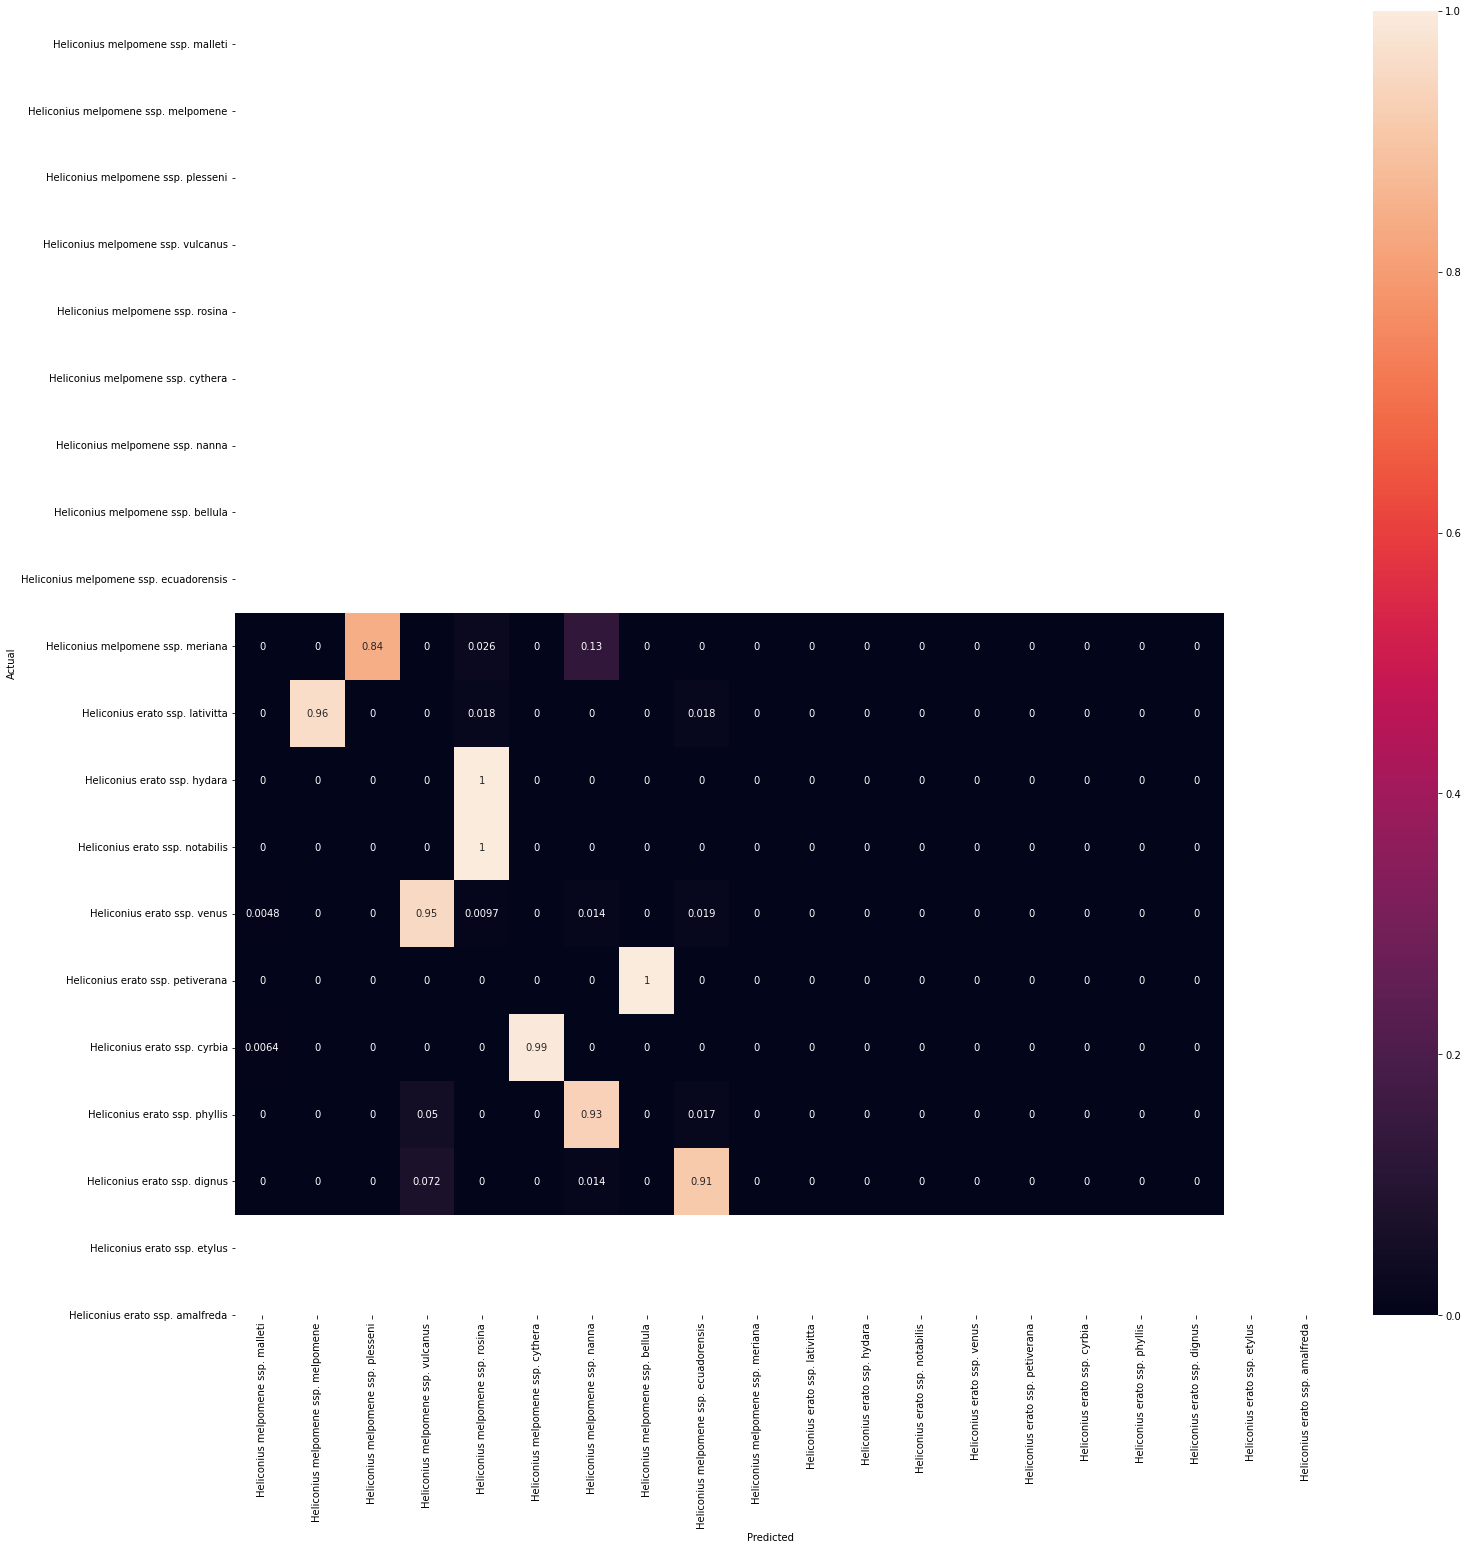

In [105]:
#something is going wrong when loading the model bc that's when we get a messed up confusion matrix!
#double check the loading function, bc when we generate the CM straight after training, it looks perfect! but after loading is when its ugly :/
accuracy_list, true, pred = get_confusion_matrix(loaders['test'], model, save_path)

# GradCam
https://jacobgil.github.io/pytorch-gradcam-book/introduction.html

In [15]:
# model
encoder #we'll only be using the encoder w/o the arcface head for gradcam (basically just the resnet50 then)

ResNetEncoder(
  (base): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [29]:
# test_images[10]
test_dataset[10][0]

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-0.2513,  0.4337, -0.0629,  ...,  0.5022, -0.5938, -1.2445],
         [-0.1999,  0.4337, -0.0287,  ..., -0.3027, -1.1247, -1.3302],
         [ 0.5022,  0.7248,  0.5707,  ..., -0.9705, -1.3302, -1.3644]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [ 0.5553,  1.5357,  0.8880,  ...,  0.8179, -0.3725, -1.0378],
         [ 0.6429,  1.6232,  0.9930,  ..., -0.0399, -0.9153, -1.1253],
         [ 1.8158,  2.0609,  1.9209,  ..., -0.7402, -1.1078, -1.1429]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


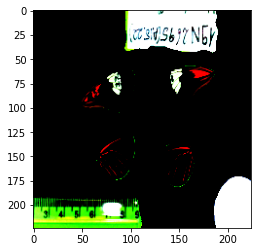

In [39]:
plt.imshow(test_dataset[0][0].permute(1,2,0))

In [42]:
target_layers = [encoder.base.layer4[-1]]

input_tensor = test_dataset[10][0].unsqueeze(0) #create an input tensor image for your model (note: input_tensor can be a batch tensor with several images)

# lativitta_features = test_embeddings[10]
    
lativitta_targets = [ClassifierOutputTarget(test_dataset[10][1])] #6 bc lativitta

#build the CAM object once and re-use it on many images
cam = GradCAM(model=encoder,
              target_layers=target_layers,
              use_cuda=True)


In [43]:
# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=lativitta_targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :] #so remove batch dim
rgb_img = np.float32(test_dataset[10][0].permute(1,2,0))/255
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
visualization = cv2.resize(visualization,(visualization.shape[1]//2, visualization.shape[0]//2))

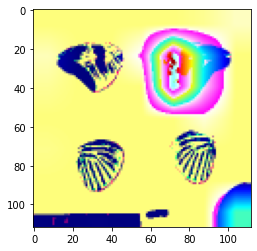

In [44]:
# from PIL import Image
# display(Image.fromarray(visualization))

plt.imshow(visualization)

def print_top_categories(model, img_tensor, top_k=5):
    logits = model(img_tensor.unsqueeze(0)).logits
    indices = logits.cpu()[0, :].detach().numpy().argsort()[-top_k :][::-1]
    for i in indices:
        print(f"Predicted class {i}: {model.config.id2label[i]}")
        


In [51]:
img_tensor = test_dataset[10][0].to(device)
img_tensor

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-0.2513,  0.4337, -0.0629,  ...,  0.5022, -0.5938, -1.2445],
         [-0.1999,  0.4337, -0.0287,  ..., -0.3027, -1.1247, -1.3302],
         [ 0.5022,  0.7248,  0.5707,  ..., -0.9705, -1.3302, -1.3644]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [ 0.5553,  1.5357,  0.8880,  ...,  0.8179, -0.3725, -1.0378],
         [ 0.6429,  1.6232,  0.9930,  ..., -0.0399, -0.9153, -1.1253],
         [ 1.8158,  2.0609,  1.9209,  ..., -0.7402, -1.1078, -1.1429]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

In [49]:
print_top_categories(encoder, img_tensor, top_k=5)

AttributeError: 'Tensor' object has no attribute 'logits'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features shape:  torch.Size([1, 128])
logits shape:  torch.Size([1, 20])
Predicted class 3: Heliconius erato ssp. phyllis
Predicted class 12: Heliconius erato ssp. amalfreda
Predicted class 0: Heliconius melpomene ssp. ecuadorensis
Predicted class 18: Heliconius erato ssp. notabilis
Predicted class 19: Heliconius melpomene ssp. melpomene


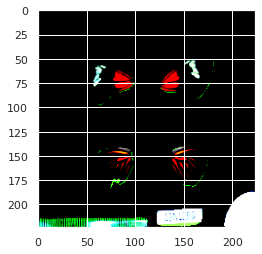

In [217]:
idx = 300

img_tensor = test_dataset[idx][0].to(device).unsqueeze(0)
target = torch.tensor(test_dataset[idx][1]).to(device).unsqueeze(0)

encoder = encoder.to(device)
features = encoder(img_tensor)
features = F.normalize(features) #do we normalize features or do we normalize after arcface hear?

arcface_head = ArcFace(128, n_classes, s=2**0.5*np.log(n_classes - 1), m=0.25).to(device)

logits = arcface_head(features, target) 

# logits = F.normalize(logits) #do we normalize here??

print('features shape: ', features.shape)
print('logits shape: ', logits.shape)

indices = logits.cpu()[0, :].detach().numpy().argsort()[-top_k :][::-1] 

#however, in our case the encoder outputs a feature vector of dim 128 - so we need to figure out how to 
#get the proper logits which should be a vector of len 20 (num classes)

for i in indices:
    print(f"Predicted class {i}: {index2species[i]}")
    
plt.imshow(img_tensor.cpu().squeeze(0).permute(1,2,0))

/fs/ess/PAS2136/Butterfly/Model_Mimic/model_mimic_images_256_256_removed_background/Heliconius erato ssp. lativitta/19N1293_d.png


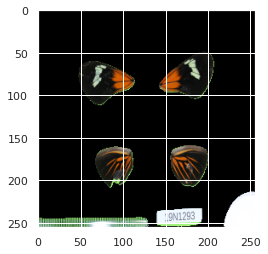

In [219]:
print(test_images[idx])
im = cv2.imread(test_images[idx])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im);

In [201]:
index2species[target.item()]

'Heliconius erato ssp. lativitta'

In [133]:
# x = input_tensor.unsqueeze(0)

# logits = encoder(x)

# output = F.normalize(logits)

# output = output.detach().cpu().numpy()

# output.shape

(1, 128)

In [140]:
input_tensor = test_dataset[10][0]#.unsqueeze(0) 
input_tensor = input_tensor.to(device)

top_k = 5

logits = encoder(input_tensor.unsqueeze(0))#.logits

#these indices are supposed to represent classes that the model predicted the highest logits for
indices = logits.cpu()[0, :].detach().numpy().argsort()[-top_k :][::-1] 

#however, in our case the encoder outputs a feature vector of dim 128 - so we need to figure out how to 
#get the proper logits which should be a vector of len 20 (num classes)

# for i in indices:
#     print(f"Predicted class {i}: {index2species[i]}")
indices

array([69,  4, 85, 25, 81])

In [85]:
model

EncoderWithHead(
  (encoder): ResNetEncoder(
    (base): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): Re